In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
series = pd.read_csv('../input/mon_trial_select.csv', engine='python', index_col=0, header=0)
print(series.head())

            modal_price
date_plus              
2014-09-01         1575
2014-11-01         1629
2015-01-01         1618
2015-02-01         1650
2015-03-01         1525


In [3]:
DTTMFormat = '%Y-%m-%d'
series.index = pd.to_datetime(series.index,format=DTTMFormat)

In [4]:
series = series.squeeze()

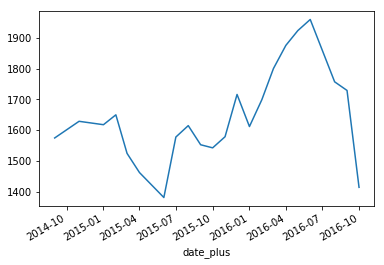

In [5]:
series.plot()
plt.show()

In [6]:
def timeseries_to_supervised(data, lag=1):
    """Frame a sequence data into a supervised learning problem, i.e., time sequence -> (X, y)"""
    df = DataFrame(data)               # DataFrame is a pandas class
    columns = [df.shift(i) for i in range(1, lag+1)]   # shift() pushed dataframe or a column vector downwards by i spaces
    columns.append(df)      # append the original as the output y onto the last column
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df

In [7]:
X = series.values
lags = 4
supervised = timeseries_to_supervised(X, lag = lags)
print(supervised.head())

        0       0       0       0     0
0     0.0     0.0     0.0     0.0  1575
1  1575.0     0.0     0.0     0.0  1629
2  1629.0  1575.0     0.0     0.0  1618
3  1618.0  1629.0  1575.0     0.0  1650
4  1650.0  1618.0  1629.0  1575.0  1525


In [8]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    # pandas.Series() turns a list like [-120.1, 37.2, ...] to a time series
    return Series(diff)

In [9]:
# invert differenced value
def inverse_difference(history, diff, interval=1):
    return diff + history[-interval]

In [10]:
differenced = difference(series, interval=1)
print("differenced:")
print(differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print("\n")
print("Inverted back:")
print(inverted.head())

differenced:
0     54
1    -11
2     32
3   -125
4    -62
dtype: int64


Inverted back:
0    1629
1    1618
2    1650
3    1525
4    1463
dtype: int64


In [11]:
def diff(dataset, interval=1):
    """My implementation of diff() function, avoiding using "for" loop. """
    history = dataset[0:-interval]
    new_output = dataset[interval:,]
    return new_output - list(history)

In [12]:
# invert differenced value
def inverse_diff(original, diff, interval=1):
    history = original[-interval]
#    print("History")
#    print(history.head())
    return diff + history

In [13]:
differenced = diff(series, 1)
print(differenced[0:5])

date_plus
2014-11-01     54
2015-01-01    -11
2015-02-01     32
2015-03-01   -125
2015-04-01    -62
Name: modal_price, dtype: int64


In [14]:
inverted = inverse_diff(series, differenced, 1)

In [15]:
print("series:")
print(series.head())
print("\nDiff:")
print(differenced.head())
print("\nInverted back:")

print(inverted.head())

series:
date_plus
2014-09-01    1575
2014-11-01    1629
2015-01-01    1618
2015-02-01    1650
2015-03-01    1525
Name: modal_price, dtype: int64

Diff:
date_plus
2014-11-01     54
2015-01-01    -11
2015-02-01     32
2015-03-01   -125
2015-04-01    -62
Name: modal_price, dtype: int64

Inverted back:
date_plus
2014-11-01    1469
2015-01-01    1404
2015-02-01    1447
2015-03-01    1290
2015-04-01    1353
Name: modal_price, dtype: int64


In [16]:
def dataset_split(dataset, train_ratio):
    """ Split dataset into train and test set by ratio of train_ratio (e.g., 0.7 for 70%). """
    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    
    return train, test

def data_scale(dataset, feature_range=(0,1)):
    """Normalize the dataset to the range of feature_range (e.g., [-1, 1]).
       Scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction.
    """
    scaler = MinMaxScaler(feature_range)
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

def data_inverse_scale(scaler, dataset):
    data_array = np.array([dataset])
    # print("data_array shape:", data_array.shape)
    data_array = data_array.reshape(1, len(data_array))
    return scaler.inverse_transform(data_array)

### Overview about different lstm networks

For LSTM model, the batch_input_shape must be in the form of (batch_size, timesteps, input_dim)

X.shape[0] provides the number of samples (rows) which is usually used as batch_size depending on the model style.

X.shape[1] provides the number of columns of X, which is usually used as the input_dim depending on the model style.

timesteps may or may not be 1.

If with_memory=True, then batch_size=1, epochs is used in "for" loop

If the model is window style, input has multi-dimentions while timesteps is 1. So batch_input_shape = (trainX.shape[0], timesteps = 1, input_dim = trainX.shape[1]

If the model is timestep style, then batch_input_size = (trainX.shape[0], timesteps = lags, input_dim = 1).

Note that after reshaping from 2D to 3D, .shape[0] and .shape[1] become .shape[1] and .shape[2].

In [17]:
def fit_lstm(units, trainset, model_style='timestep', with_memory=False, epochs=50): 
    
    X, y = trainset[:, 0:-1], trainset[:, -1]  # the last column is y, the rest belongs to X (which excludes the last column)

    samples = X.shape[0]   # number of samples in the training set
    
    if model_style is 'window':
        timesteps = 1
        input_dim = X.shape[1]
    elif model_style is 'timestep':
        timesteps = X.shape[1]
        input_dim = 1
    
    X = X.reshape(samples, timesteps, input_dim)   # turn X from 2D to 3D
    
    batch_size = 1         # always 1 for time-series models
    timesteps = X.shape[1]
    input_dim = X.shape[2]
    
    batch_input_shape=(batch_size, timesteps, input_dim)
    
    model = Sequential()
    
    if with_memory is True:
        
        model.add(LSTM(units, batch_input_shape= batch_input_shape, stateful=True))
        # model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), stateful=True))

        model.add(Dense(10)) 
        model.add(Dense(1))
        
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        for i in range(epochs):
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
            model.reset_states()
            
    else:
        model.add(LSTM(units, batch_input_shape= batch_input_shape))
        model.add(Dense(10))
        #model.add(Dropout(0.8))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2) 
    
    return model

In [18]:
def forecast_lstm(model, data, batch_size=1, model_style='window'):
    """ Making predictions that support two modes: static mode and dynamic mode.
        
        In static mode, input data has only one row and 2D, so should be reshaped to 3D first by adding batch_size to the 1st dimension.
        Output of model.predict has 2D of 1x1 array, and this function returns its value, so takes the value from array by index [0, 0].
        
        Note that to maintain consistency with dynamic mode (see below), input data includes the last column which sould be split into X
        and y (last column) before everything else because dynamic mode requires y (labels) in addition to X but static mode doesn't.
        
        In dynamic mode, input data has multiple rows and the model will be "fit" over input data again except its last row.
        Then predict is made over the last row.
    """
    X, y = data[:, 0:-1], data[:, -1]
    
    rows, cols = X.shape     # no matter what mode, input data has 2D with 1 or multiple rows
    # print('rows=%d, cols=%d' % (rows, cols))
    
    if model_style is 'window':
        timesteps = 1
        input_dim = cols
    elif model_style is 'timestep':
        timesteps = cols
        input_dim = 1
        
    X = X.reshape(batch_size, timesteps, input_dim)   # trun 2D input data to 3D that is required by LSTM model

    predict_data = model.predict(X, batch_size=batch_size)
    ret_value = predict_data[0, 0]       # get the value from 1x1 array predict_data
    
    return ret_value

In [19]:
raw_values = series.values

In [20]:
print("Shape of dataset:", raw_values.shape)
print("5 samples of dataset:", raw_values[0:5])

Shape of dataset: (22,)
5 samples of dataset: [1575 1629 1618 1650 1525]


In [21]:
diff_values = difference(raw_values, interval=1)
print(diff_values[0:5])

0     54
1    -11
2     32
3   -125
4    -62
dtype: int64


In [22]:
diff_values = diff(raw_values, interval=1)
print(diff_values[0:5])

[  54  -11   32 -125  -62]


In [23]:
inv_diff = inverse_diff(raw_values, diff_values, interval=1)
print(inv_diff[0:5])

[1469 1404 1447 1290 1353]


In [24]:
diff_values = diff_values.reshape(-1, 1)
print(diff_values.shape)
scaler, data_scaled = data_scale(diff_values, feature_range=(-1,1))

(21, 1)


In [25]:
lags = 1
supervised_dataframe = timeseries_to_supervised(data_scaled, lag=lags)

In [26]:
supervised_data = supervised_dataframe.values

In [27]:
train, test = dataset_split(supervised_data, train_ratio=0.67)

### LSTM Model Timestep and no memory

In [28]:
units = 8
epochs = 100
model = fit_lstm(units, train, model_style='timestep', with_memory=False, epochs=epochs)

Epoch 1/100
 - 1s - loss: 0.1832
Epoch 2/100
 - 0s - loss: 0.1658
Epoch 3/100
 - 0s - loss: 0.1474
Epoch 4/100
 - 0s - loss: 0.1402
Epoch 5/100
 - 0s - loss: 0.1336
Epoch 6/100
 - 0s - loss: 0.1291
Epoch 7/100
 - 0s - loss: 0.1267
Epoch 8/100
 - 0s - loss: 0.1255
Epoch 9/100
 - 0s - loss: 0.1245
Epoch 10/100
 - 0s - loss: 0.1264
Epoch 11/100
 - 0s - loss: 0.1252
Epoch 12/100
 - 0s - loss: 0.1234
Epoch 13/100
 - 0s - loss: 0.1219
Epoch 14/100
 - 0s - loss: 0.1211
Epoch 15/100
 - 0s - loss: 0.1216
Epoch 16/100
 - 0s - loss: 0.1211
Epoch 17/100
 - 0s - loss: 0.1218
Epoch 18/100
 - 0s - loss: 0.1195
Epoch 19/100
 - 0s - loss: 0.1192
Epoch 20/100
 - 0s - loss: 0.1193
Epoch 21/100
 - 0s - loss: 0.1203
Epoch 22/100
 - 0s - loss: 0.1196
Epoch 23/100
 - 0s - loss: 0.1186
Epoch 24/100
 - 0s - loss: 0.1179
Epoch 25/100
 - 0s - loss: 0.1179
Epoch 26/100
 - 0s - loss: 0.1181
Epoch 27/100
 - 0s - loss: 0.1188
Epoch 28/100
 - 0s - loss: 0.1188
Epoch 29/100
 - 0s - loss: 0.1177
Epoch 30/100
 - 0s - lo

In [30]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test)):
    # make one-step forecast

    data = test[i]
    data = data.reshape(1, len(data))    # turn 1D to 2D
    predicted_value = forecast_lstm(model, data, batch_size=1, model_style='timestep')
    
    #print("predicted_value:", predicted_value)
    # invert scaling
    predicted_value = data_inverse_scale(scaler, predicted_value)
    #print("inverse-scaled predicted value:", predicted_value[0, 0])
    
    # invert differencing
    predicted_values = inverse_diff(raw_values, predicted_value[0, 0], interval=len(test)+1-i)
    #print("inverse-diff predicted value: ", predicted_values)

    # store forecast
    predictions.append(predicted_values)
    expected = raw_values[len(train)+i]
    expected_list.append(expected)
    #print("expected:", expected)
    print('Month=%d, Predicted=%.2f, Expected=%.2f' % (i+1, predicted_values, expected))

Month=1, Predicted=1685.55, Expected=1699.00
Month=2, Predicted=1783.84, Expected=1800.00
Month=3, Predicted=1863.97, Expected=1875.00
Month=4, Predicted=1917.71, Expected=1923.00
Month=5, Predicted=1956.39, Expected=1959.00
Month=6, Predicted=1822.34, Expected=1757.00
Month=7, Predicted=1742.02, Expected=1729.00


In [31]:
# report performance
rmse = sqrt(mean_squared_error(expected_list, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.827


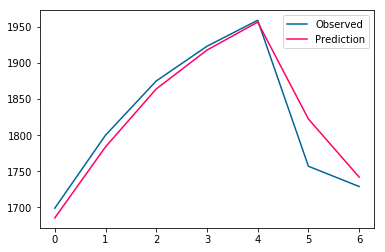

In [32]:
# line plot of observed vs predicted
plt.plot(expected_list, label='Observed', color='#006699')
plt.plot(predictions, label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()

### LSTM Window with memory

In [29]:
model_ts_mem = fit_lstm(units, train, model_style='window', with_memory=True, epochs=epochs)

Epoch 1/1
 - 1s - loss: 0.1906
Epoch 1/1
 - 0s - loss: 0.1611
Epoch 1/1
 - 0s - loss: 0.1431
Epoch 1/1
 - 0s - loss: 0.1335
Epoch 1/1
 - 0s - loss: 0.1288
Epoch 1/1
 - 0s - loss: 0.1265
Epoch 1/1
 - 0s - loss: 0.1254
Epoch 1/1
 - 0s - loss: 0.1246
Epoch 1/1
 - 0s - loss: 0.1240
Epoch 1/1
 - 0s - loss: 0.1234
Epoch 1/1
 - 0s - loss: 0.1228
Epoch 1/1
 - 0s - loss: 0.1223
Epoch 1/1
 - 0s - loss: 0.1218
Epoch 1/1
 - 0s - loss: 0.1213
Epoch 1/1
 - 0s - loss: 0.1208
Epoch 1/1
 - 0s - loss: 0.1203
Epoch 1/1
 - 0s - loss: 0.1199
Epoch 1/1
 - 0s - loss: 0.1195
Epoch 1/1
 - 0s - loss: 0.1191
Epoch 1/1
 - 0s - loss: 0.1187
Epoch 1/1
 - 0s - loss: 0.1183
Epoch 1/1
 - 0s - loss: 0.1179
Epoch 1/1
 - 0s - loss: 0.1175
Epoch 1/1
 - 0s - loss: 0.1172
Epoch 1/1
 - 0s - loss: 0.1169
Epoch 1/1
 - 0s - loss: 0.1165
Epoch 1/1
 - 0s - loss: 0.1162
Epoch 1/1
 - 0s - loss: 0.1160
Epoch 1/1
 - 0s - loss: 0.1157
Epoch 1/1
 - 0s - loss: 0.1154
Epoch 1/1
 - 0s - loss: 0.1152
Epoch 1/1
 - 0s - loss: 0.1149
Epoch 1/

In [33]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test)):
    # make one-step forecast

    data = test[i]
    data = data.reshape(1, len(data))    # turn 1D to 2D
    predicted_value = forecast_lstm(model_ts_mem, data, batch_size=1, model_style='window')
    
    #print("predicted_value:", predicted_value)
    # invert scaling
    predicted_value = data_inverse_scale(scaler, predicted_value)
    #print("inverse-scaled predicted value:", predicted_value[0, 0])
    
    # invert differencing
    predicted_values = inverse_diff(raw_values, predicted_value[0, 0], interval=len(test)+1-i)
    #print("inverse-diff predicted value: ", predicted_values)

    # store forecast
    predictions.append(predicted_values)
    expected = raw_values[len(train)+i]
    expected_list.append(expected)
    
    #print("expected:", expected)
    print('Month=%d, Predicted=%.2f, Expected=%.2f' % (i+1, predicted_values, expected))

Month=1, Predicted=1688.23, Expected=1699.00
Month=2, Predicted=1758.39, Expected=1800.00
Month=3, Predicted=1811.38, Expected=1875.00
Month=4, Predicted=1846.53, Expected=1923.00
Month=5, Predicted=1873.66, Expected=1959.00
Month=6, Predicted=1737.40, Expected=1757.00
Month=7, Predicted=1716.61, Expected=1729.00


In [34]:
# report performance
rmse = sqrt(mean_squared_error(expected_list, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 52.864


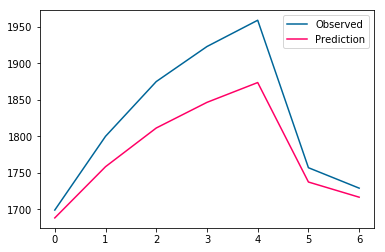

In [37]:
# line plot of observed vs predicted
plt.plot(expected_list, label='Observed', color='#006699')
plt.plot(predictions, label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()

### LSTM window with no memory

In [36]:
model_ts_no_mem = fit_lstm(units, train, model_style='window', with_memory=False, epochs=epochs)

Epoch 1/100
 - 1s - loss: 0.1949
Epoch 2/100
 - 0s - loss: 0.1709
Epoch 3/100
 - 0s - loss: 0.1512
Epoch 4/100
 - 0s - loss: 0.1375
Epoch 5/100
 - 0s - loss: 0.1302
Epoch 6/100
 - 0s - loss: 0.1257
Epoch 7/100
 - 0s - loss: 0.1244
Epoch 8/100
 - 0s - loss: 0.1218
Epoch 9/100
 - 0s - loss: 0.1211
Epoch 10/100
 - 0s - loss: 0.1204
Epoch 11/100
 - 0s - loss: 0.1197
Epoch 12/100
 - 0s - loss: 0.1196
Epoch 13/100
 - 0s - loss: 0.1194
Epoch 14/100
 - 0s - loss: 0.1194
Epoch 15/100
 - 0s - loss: 0.1191
Epoch 16/100
 - 0s - loss: 0.1186
Epoch 17/100
 - 0s - loss: 0.1186
Epoch 18/100
 - 0s - loss: 0.1201
Epoch 19/100
 - 0s - loss: 0.1194
Epoch 20/100
 - 0s - loss: 0.1182
Epoch 21/100
 - 0s - loss: 0.1189
Epoch 22/100
 - 0s - loss: 0.1174
Epoch 23/100
 - 0s - loss: 0.1176
Epoch 24/100
 - 0s - loss: 0.1188
Epoch 25/100
 - 0s - loss: 0.1175
Epoch 26/100
 - 0s - loss: 0.1174
Epoch 27/100
 - 0s - loss: 0.1182
Epoch 28/100
 - 0s - loss: 0.1173
Epoch 29/100
 - 0s - loss: 0.1177
Epoch 30/100
 - 0s - lo

In [38]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test)):
    # make one-step forecast

    data = test[i]
    data = data.reshape(1, len(data))    # turn 1D to 2D
    predicted_value = forecast_lstm(model_ts_no_mem, data, batch_size=1, model_style='window')
    
    #print("predicted_value:", predicted_value)
    # invert scaling
    predicted_value = data_inverse_scale(scaler, predicted_value)
    #print("inverse-scaled predicted value:", predicted_value[0, 0])
    
    # invert differencing
    predicted_values = inverse_diff(raw_values, predicted_value[0, 0], interval=len(test)+1-i)
    #print("inverse-diff predicted value: ", predicted_values)

    # store forecast
    predictions.append(predicted_values)
    expected = raw_values[len(train)+i]
    expected_list.append(expected)
    
    #print("expected:", expected)
    print('Month=%d, Predicted=%.2f, Expected=%.2f' % (i+1, predicted_values, expected))

Month=1, Predicted=1687.73, Expected=1699.00
Month=2, Predicted=1785.81, Expected=1800.00
Month=3, Predicted=1866.28, Expected=1875.00
Month=4, Predicted=1920.19, Expected=1923.00
Month=5, Predicted=1958.87, Expected=1959.00
Month=6, Predicted=1814.71, Expected=1757.00
Month=7, Predicted=1743.78, Expected=1729.00


In [39]:
# report performance
rmse = sqrt(mean_squared_error(expected_list, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.790


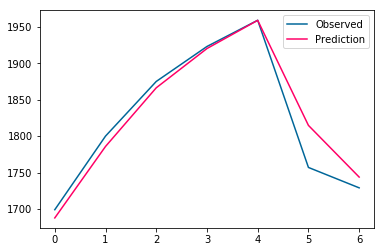

In [40]:
# line plot of observed vs predicted
plt.plot(expected_list, label='Observed', color='#006699')
plt.plot(predictions, label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()

### LSTM time step with memory

In [41]:
model_mem = fit_lstm(units, train, model_style='timestep', with_memory=True, epochs=epochs)

Epoch 1/1
 - 1s - loss: 0.1659
Epoch 1/1
 - 0s - loss: 0.1489
Epoch 1/1
 - 0s - loss: 0.1402
Epoch 1/1
 - 0s - loss: 0.1361
Epoch 1/1
 - 0s - loss: 0.1341
Epoch 1/1
 - 0s - loss: 0.1328
Epoch 1/1
 - 0s - loss: 0.1318
Epoch 1/1
 - 0s - loss: 0.1310
Epoch 1/1
 - 0s - loss: 0.1302
Epoch 1/1
 - 0s - loss: 0.1294
Epoch 1/1
 - 0s - loss: 0.1287
Epoch 1/1
 - 0s - loss: 0.1280
Epoch 1/1
 - 0s - loss: 0.1273
Epoch 1/1
 - 0s - loss: 0.1267
Epoch 1/1
 - 0s - loss: 0.1261
Epoch 1/1
 - 0s - loss: 0.1255
Epoch 1/1
 - 0s - loss: 0.1249
Epoch 1/1
 - 0s - loss: 0.1243
Epoch 1/1
 - 0s - loss: 0.1238
Epoch 1/1
 - 0s - loss: 0.1233
Epoch 1/1
 - 0s - loss: 0.1227
Epoch 1/1
 - 0s - loss: 0.1223
Epoch 1/1
 - 0s - loss: 0.1218
Epoch 1/1
 - 0s - loss: 0.1213
Epoch 1/1
 - 0s - loss: 0.1209
Epoch 1/1
 - 0s - loss: 0.1205
Epoch 1/1
 - 0s - loss: 0.1200
Epoch 1/1
 - 0s - loss: 0.1196
Epoch 1/1
 - 0s - loss: 0.1193
Epoch 1/1
 - 0s - loss: 0.1189
Epoch 1/1
 - 0s - loss: 0.1185
Epoch 1/1
 - 0s - loss: 0.1182
Epoch 1/

In [42]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test)):
    # make one-step forecast

    data = test[i]
    data = data.reshape(1, len(data))    # turn 1D to 2D
    predicted_value = forecast_lstm(model_mem, data, batch_size=1, model_style='window')
    
    #print("predicted_value:", predicted_value)
    # invert scaling
    predicted_value = data_inverse_scale(scaler, predicted_value)
    #print("inverse-scaled predicted value:", predicted_value[0, 0])
    
    # invert differencing
    predicted_values = inverse_diff(raw_values, predicted_value[0, 0], interval=len(test)+1-i)
    #print("inverse-diff predicted value: ", predicted_values)

    # store forecast
    predictions.append(predicted_values)
    expected = raw_values[len(train)+i]
    expected_list.append(expected)
    
    #print("expected:", expected)
    print('Month=%d, Predicted=%.2f, Expected=%.2f' % (i+1, predicted_values, expected))

Month=1, Predicted=1691.65, Expected=1699.00
Month=2, Predicted=1760.80, Expected=1800.00
Month=3, Predicted=1817.53, Expected=1875.00
Month=4, Predicted=1861.19, Expected=1923.00
Month=5, Predicted=1899.85, Expected=1959.00
Month=6, Predicted=1782.16, Expected=1757.00
Month=7, Predicted=1764.74, Expected=1729.00


In [43]:
# report performance
rmse = sqrt(mean_squared_error(expected_list, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 44.916


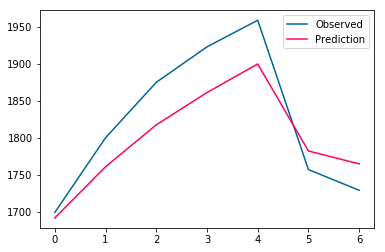

In [44]:
# line plot of observed vs predicted
plt.plot(expected_list, label='Observed', color='#006699')
plt.plot(predictions, label='Prediction', color='#ff0066')
plt.legend(loc='best');
plt.show()